In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
%matplotlib inline

In [69]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [151]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.grad = 0.0
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self.label = label
        self._op = _op
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def backward():
            self.grad += out.grad * other * self.data**(other - 1)
            #other.grad += out.grad * math.log(self.data) * self.data**other.data
        out._backward = backward
        
        return out
        
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self*other**-1
    
    def __neg__(self):
        return -1*self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self - other
    
    def __radd__(self, other):
        return self + other        
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def backward():
            self.grad += out.grad*out.data
        
        out._backward = backward
        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        for v in reversed(topo):
            v._backward()
        

In [219]:
class Neuron:
    
    def __init__(self, n_inputs):
        self.weights = [Value(np.random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.bias = Value(np.random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.weights, x)), self.bias)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.weights + [self.bias]
    

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
        
        def __init__(self, nin, nouts):
            sz = [nin] + nouts
            self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
            
        def __call__(self, x):
            for layer in self.layers:
                x = layer(x)
            return x
        
        def parameters(self):
            return [p for layer in self.layers for p in layer.parameters()]
            

In [220]:
x = [2.0, 3.0, 7.0]
n = MLP(3, [4,4,1])

In [221]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]



In [222]:
for k in range(10):
    # forward
    ypred = [n(x) for x in xs]
    loss = sum((yi - y)**2 for yi, y in zip(ys, ypred))
    
    # backward
    loss.backward()
    
    # Gradient Descent
    for p in n.parameters():
        p.data -= 0.05 * p.grad
        p.grad = 0.0
        
    print(k, loss.data)
    

0 3.028787373430469
1 2.03144457515073
2 1.2627085901386081
3 0.7913509190085944
4 0.5435001854520035
5 0.39244889133642236
6 0.29444115228333323
7 0.22874571703324398
8 0.18326914534863775
9 0.1507469641189822


In [200]:
ypred = [n(x) for x in xs]
loss = sum((yi - y)**2 for yi, y in zip(ys, ypred))
print(loss)

Value(data=0.0004478545862098668)


In [201]:
loss.backward()

In [202]:
for p in n.parameters():
    p.data -= 0.01 * p.grad

In [203]:
ypred

[Value(data=0.9830833814447942),
 Value(data=-0.9987816689004779),
 Value(data=-0.9987255227682768),
 Value(data=0.987407383910192)]

In [79]:
a = Value(2, label='a')
b = Value(3, label='b')
c = Value(10, label='c')
d = a*b + c


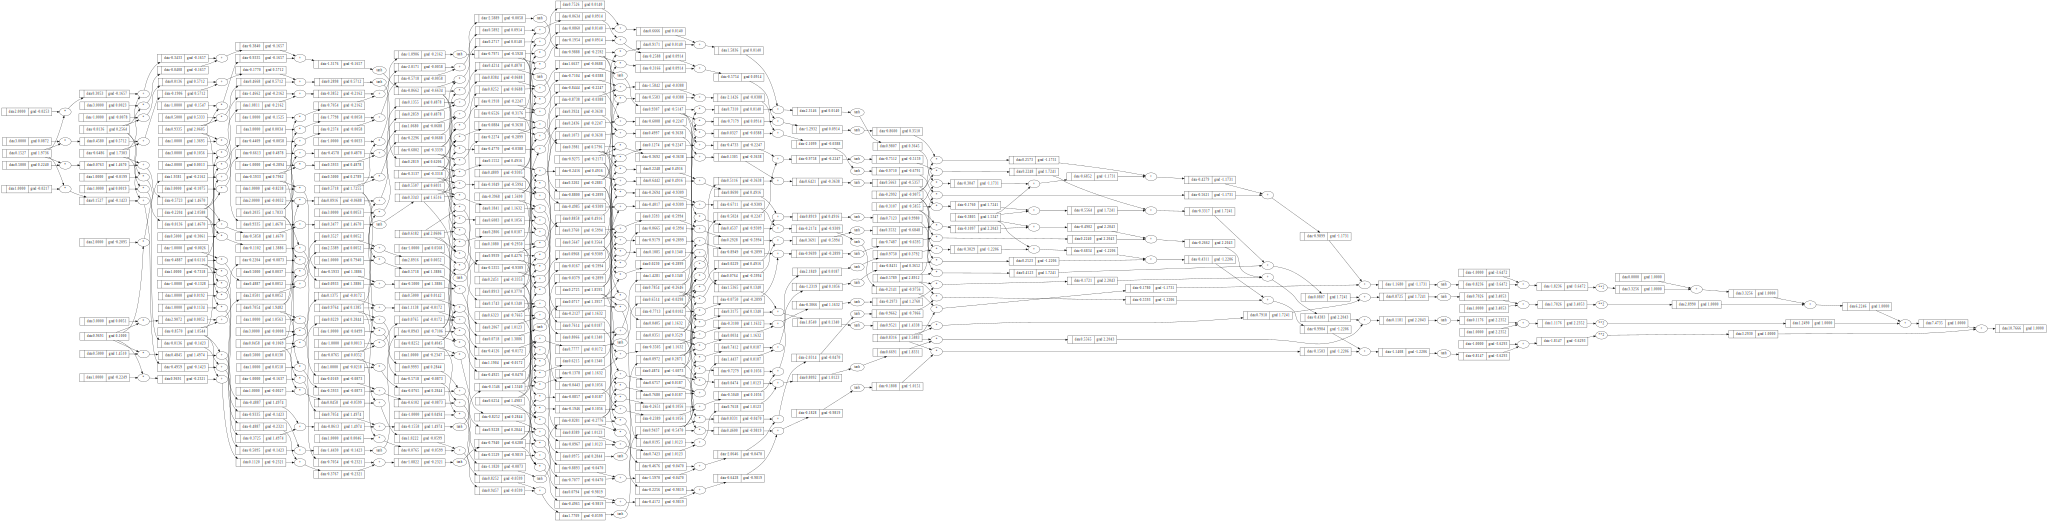

In [156]:
draw_dot(loss)

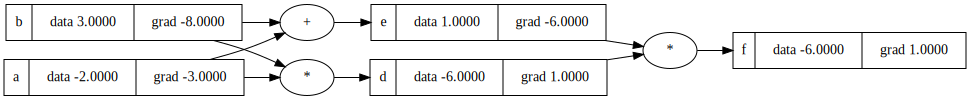

In [84]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)